In [1]:
# Description: Plot Figure 14 (Time series of terms in the cross-shelf momentum balance).
# Author:      André Palóczy
# E-mail:      paloczy@gmail.com
# Date:        December/2020

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas import Timestamp
from xarray import DataArray, open_dataset
from gsw import f as fcor

In [3]:
def extrapna_nearest(arr, z):
    for j in range(arr.shape[1]):
        fg = ~np.isnan(arr[:, j])
        if not fg.any():
            continue
        arrg = arr[fg, j]
        zg = z[fg]
        arr[:, j] = np.interp(z, zg, arrg)

    return arr

In [4]:
plt.close('all')
head = "../../data_reproduce_figs/"
avg_hours = 2

#----- OC25SA
zcap = 17
ds1OC25SA = open_dataset(head+'OC25SA-Ad1rs5-10min_ensembles-nobinmap-bias-corrected.nc').sel(dict(z=slice(0, zcap)))

In [5]:
# Coriolis term.
lat0 = 35
f0 = fcor(lat0)
ds1OC25SA['-fv'] = -f0*ds1OC25SA['v'].mean('z')

In [6]:
# Vertical Reynolds stress divergence term.
ds1OC25SA['-duwdz'] = -ds1OC25SA['uw'].differentiate('z').mean('z')
ds1OC25SA['-dvwdz'] = -ds1OC25SA['vw'].differentiate('z').mean('z')

# Vertical advection of cross-shelf momentum term.
ds1OC25SA['wdudz'] = (ds1OC25SA['w5']*ds1OC25SA['u']).differentiate('z').mean('z')
ds1OC25SA['wdvdz'] = (ds1OC25SA['w5']*ds1OC25SA['v']).differentiate('z').mean('z')

In [7]:
# Density contribution to the cross-shelf pressure gradient term.
Lx = 2.0e3 # [m] Distance between OC25SA and OC40S.
dbar2Pa = 1e4

# - g*d/dx ( rhoint ) term.
TOC40S = open_dataset(head+"OC40S-T.nc")['T']
TOC25SA = open_dataset(head+"OC25SA-T.nc")['T']

# Calculate 10 min-averages for consistency with other terms (T data originally every 30 s)
TOC40S = TOC40S.resample(t='10 min').mean('t')
TOC25SA = TOC25SA.resample(t='10 min').mean('t')

rho0 = 1024.0 # [kg/m3].
alpha = 2.65e-4 # [1/K]
g = 9.81        # [m/s2]
h = 25.0        # [m]
T0 = 21.0       # [degrees C], reference T that gives rho = 1024 kg/m3 at 0 dbar and SA = 34.5.
rhoOC40S = rho0*(1 - alpha*(TOC40S - T0)).interpolate_na('z').interpolate_na('t')
rhoOC25SA = rho0*(1 - alpha*(TOC25SA - T0)).interpolate_na('z').interpolate_na('t')

# Fill all NaNs near the surface so that they don't bias the integrals.
rhoOC40S = DataArray(extrapna_nearest(rhoOC40S.values, rhoOC40S['z'].values), coords=rhoOC40S.coords, dims=rhoOC40S.dims)
rhoOC25SA = DataArray(extrapna_nearest(rhoOC25SA.values, rhoOC25SA['z'].values), coords=rhoOC25SA.coords, dims=rhoOC25SA.dims)

dz = 1.0 # dz is constant and equal to 1 m in these two T-chains.
rhoOC40S['z'] = -rhoOC40S['z']
rhoOC25SA['z'] = -rhoOC25SA['z']

IrhoOC40S = np.nansum(rhoOC40S.values*dz, axis=0)
IrhoOC25SA = np.nansum(rhoOC25SA.values*dz, axis=0)
IrhoOC40S = DataArray(IrhoOC40S, coords=dict(t=rhoOC40S.coords['t']), dims='t')
IrhoOC25SA = DataArray(IrhoOC25SA, coords=dict(t=rhoOC25SA.coords['t']), dims='t')

IrhoOC40S = IrhoOC40S.interp_like(IrhoOC25SA)
aux1 = g*(IrhoOC25SA - IrhoOC40S)/Lx/rho0
pOC25SA = ds1OC25SA['p']
aux1 = aux1.interp_like(pOC25SA)

drho = rhoOC25SA - rhoOC40S
Irhox = np.nansum(drho.values*dz, axis=0)
aux2 = DataArray(g*Irhox/Lx/rho0, coords=dict(t=drho.coords['t']), dims='t')
aux2 = aux2.interp_like(pOC25SA)
z = drho['z'].values[:,np.newaxis]
Irhoxz = np.nansum(drho.values*z*dz, axis=0)
aux3 = DataArray(g*Irhoxz/Lx/rho0/h, coords=dict(t=drho.coords['t']), dims='t')
aux3 = aux3.interp_like(pOC25SA)
dPdensdx = - aux2 - aux3
ds1OC25SA["-dPdensdx"] = dPdensdx.interp_like(ds1OC25SA['-fv'])

In [8]:
# Calculate hourly averages for all momentum balance terms.
ds1OC25SA = ds1OC25SA.resample(dict(t="%dh"%avg_hours)).mean('t')

(-6.0, 6.0)

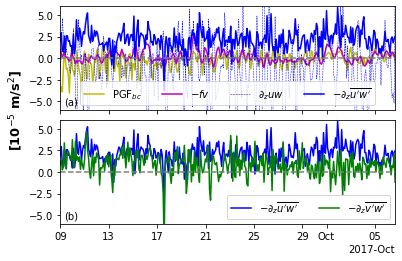

In [9]:
# Plotting.
fac = 1e5
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
ax1, ax2 = ax

t = ds1OC25SA['t']
ax1.plot(t, ds1OC25SA['-dPdensdx'].values*fac, 'y', label="PGF$_{bc}$")
ax1.plot(t, ds1OC25SA['-fv'].values*fac, 'm', label="$-fv$")
ax1.plot(t, ds1OC25SA['wdudz'].values*fac, 'b', linewidth=0.5, linestyle='dashed', label="$\partial_zuw$")
ax1.plot(t, ds1OC25SA['-duwdz'].values*fac, 'b', label="$-\partial_z\overline{u'w'}$")

ax2.plot(t, ds1OC25SA['-duwdz'].values*fac, 'b', label="$-\partial_z\overline{u'w'}$")
ax2.plot(t, ds1OC25SA['-dvwdz'].values*fac, 'g', label="$-\partial_z\overline{v'w'}$")
ax1.axhline(color='gray', ls='--')
ax2.axhline(color='gray', ls='--')
ax1.set_xlim(Timestamp("2017-09-09 00:00:00"), t.values[-1])

ax1.legend(frameon=True, ncol=4, loc="lower center")
ax2.legend(frameon=True, ncol=3, loc="lower right")

xt, yt = 0.01, 0.05
ax1.text(xt, yt, r"(a)", transform=ax1.transAxes)
ax2.text(xt, yt, r"(b)", transform=ax2.transAxes)

fig.subplots_adjust(hspace=0.1)
locator = mdates.AutoDateLocator(minticks=8, maxticks=14)
formatter = mdates.ConciseDateFormatter(locator)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax1.set_ylabel("[10$^{-5}$ m/s$^2$]", fontsize=13, fontweight="black", y=0)
ax1.set_ylim(-6, 6)

In [10]:
fig.savefig("fig14.png", bbox_inches="tight", dpi=200)